## 패키지 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

import tensorflow as tf
# 이미지 데이터 증강
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# image albumentation
import albumentations as at

# 최적화
from tensorflow.keras.optimizers import RMSprop

import os
import cv2
import PIL
import shutil

In [ ]:
# 파일 압축 풀기
# %cd 압축을 풀 경로
# !unzip -qq "압축파일 Path"

%cd /content/drive/MyDrive/6dogma/res
!unzip -qq "/content/drive/MyDrive/6dogma/res/resized.zip"

/content/drive/MyDrive/6dogma/res


## 이미지 데이터 불러오기

In [2]:
# 기본 경로
base_dir = '/content/drive/MyDrive/6dogma/res/resized/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# 훈련용 Good/Bad 이미지 경로
train_G_dir = os.path.join(train_dir, 'Good')
train_B_dir = os.path.join(train_dir, 'bad')
print(train_G_dir, train_B_dir)

# 테스트용 Good/Bad 이미지 경로
test_G_dir = os.path.join(test_dir, 'Good')
test_B_dir = os.path.join(test_dir, 'bad')
print(test_G_dir, test_B_dir)

/content/drive/MyDrive/6dogma/res/resized/train/Good /content/drive/MyDrive/6dogma/res/resized/train/bad
/content/drive/MyDrive/6dogma/res/resized/test/Good /content/drive/MyDrive/6dogma/res/resized/test/bad


In [3]:
# 훈련용 이미지 파일 이름 조회

train_G_fnames = os.listdir(train_G_dir)
train_B_fnames = os.listdir(train_B_dir)
print(train_G_fnames)
print(train_B_fnames)

['KEMP_IMG_DATA_1107.png', 'KEMP_IMG_DATA_1106.png', 'KEMP_IMG_DATA_1108.png', 'KEMP_IMG_DATA_111.png', 'KEMP_IMG_DATA_1109.png', 'KEMP_IMG_DATA_1110.png', 'KEMP_IMG_DATA_1111.png', 'KEMP_IMG_DATA_1112.png', 'KEMP_IMG_DATA_1113.png', 'KEMP_IMG_DATA_1115.png', 'KEMP_IMG_DATA_1117.png', 'KEMP_IMG_DATA_1118.png', 'KEMP_IMG_DATA_1119.png', 'KEMP_IMG_DATA_112.png', 'KEMP_IMG_DATA_1122.png', 'KEMP_IMG_DATA_1124.png', 'KEMP_IMG_DATA_1126.png', 'KEMP_IMG_DATA_1125.png', 'KEMP_IMG_DATA_1127.png', 'KEMP_IMG_DATA_1129.png', 'KEMP_IMG_DATA_1128.png', 'KEMP_IMG_DATA_113.png', 'KEMP_IMG_DATA_1133.png', 'KEMP_IMG_DATA_1134.png', 'KEMP_IMG_DATA_1135.png', 'KEMP_IMG_DATA_1136.png', 'KEMP_IMG_DATA_1139.png', 'KEMP_IMG_DATA_1138.png', 'KEMP_IMG_DATA_114.png', 'KEMP_IMG_DATA_1141.png', 'KEMP_IMG_DATA_1140.png', 'KEMP_IMG_DATA_1144.png', 'KEMP_IMG_DATA_1146.png', 'KEMP_IMG_DATA_1145.png', 'KEMP_IMG_DATA_1147.png', 'KEMP_IMG_DATA_1149.png', 'KEMP_IMG_DATA_1148.png', 'KEMP_IMG_DATA_1150.png', 'KEMP_IMG_DATA_

In [4]:
# 각 디렉토리에 저장되어 있는 이미지 파일 수 확인

print('Total training G images :', len(os.listdir(train_G_dir)))
print('Total training B images :', len(os.listdir(train_B_dir)))

print('Total test G images :', len(os.listdir(test_G_dir)))
print('Total test B images :', len(os.listdir(test_B_dir)))

Total training G images : 1102
Total training B images : 59
Total test G images : 275
Total test B images : 14


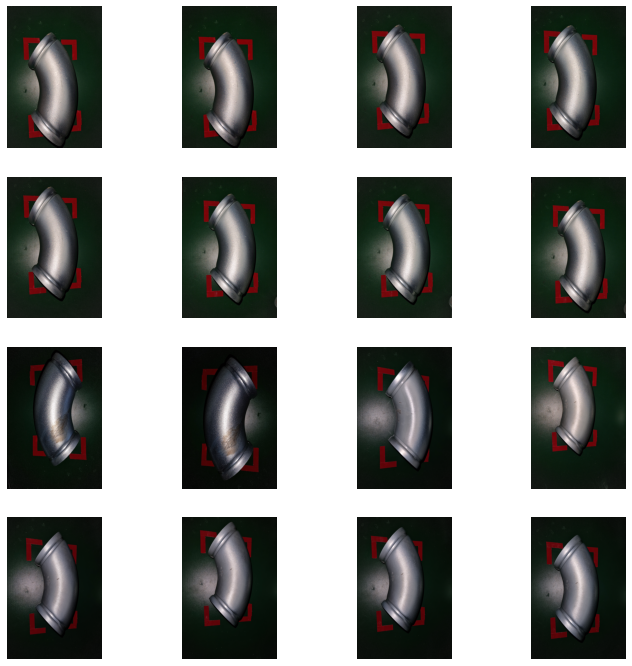

In [5]:
# 이미지 확인

nrows, ncols = 4, 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index += 8

next_G_pix = [os.path.join(train_G_dir, fname) for fname in train_G_fnames[pic_index-8:pic_index]]
next_B_pix = [os.path.join(train_B_dir, fname) for fname in train_B_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_G_pix+next_B_pix):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('OFF')
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

## 이미지 데이터 증강

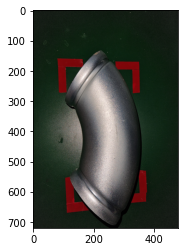

In [6]:
# 이미지 하나 불러오기
sample_img = mpimg.imread(next_G_pix[0])
sample_img = cv2.cvtColor(cv2.imread(next_G_pix[0]), cv2.COLOR_BGR2RGB).copy()
plt.imshow(sample_img)
plt.show()

In [10]:
# 이미지 증강 관련 함수

def show_images(images, labels):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))
    for i in range(5):
        axs[i].imshow(images[i])
        axs[i].set_title(labels[i])

# 원본 이미지를 입력받아 augmentation 적용하여 시각화
def aug_apply(image, label, aug):
    image_list = [image]
    label_list = ['origin']

    for i in range(5):
      aug_image = aug(image=image)['image']
      image_list.append(aug_image)
      label_list.append(label)

    show_images(image_list, label_list)

In [17]:
# 좌우 반전
aug_horizontal = at.HorizontalFlip(p=0.5)
# 상하 반전
aug_vertical = at.VerticalFlip(p=0.5)
# -90 ~ 90도 사이로 돌림, 남은 공간은 주변 환경으로 채움 (cv2.BORDER_CONSTAN, cv2.BORDER_REFLECT, cv2.BORDER_REFLECT_101, cv2.BORDER_WRAP)
aug_rotate = at.Rotate(limit=90, p=0.5, border_mode=cv2.BORDER_REPLICATE)
# 원본사이즈를 변경 하면서 90, 180, 270, 360도 돌림
aug_random_rotate = at.RandomRotate90(p=1)
# 노이즈
aug_GaussNoise = at.GaussNoise(var_limit=(10.0, 50.0), mean=11, per_channel=True, always_apply=False, p=1)
#ISONoise
aug_ISONoise  = at.ISONoise ( color_shift=(0.01, 0.5), intensity=(0.5, 0.7), p=1 )
#RGBShift
aug_RGBShift  = at.RGBShift ( r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1)

aug_apply(image=sample_img, label='Horizontal', aug=aug_horizontal)
aug_apply(image=sample_img, label='Vertical', aug=aug_vertical)
aug_apply(image=sample_img, label='Rotate', aug=aug_rotate)
aug_apply(image=sample_img, label='RandomRotate', aug=aug_random_rotate)
aug_apply(image=sample_img, label='GaussNoise', aug=aug_GaussNoise)
aug_apply(image=sample_img, label='ISONoise', aug=aug_ISONoise)
aug_apply(image=sample_img, label='RGBShif', aug=aug_RGBShift)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sample_img.shape

(720, 480, 3)

In [ ]:
train_datagen = aug_apply(image=sample_img, label='Horizontal', aug=aug_horizontal),
                aug_apply(image=sample_img, label='Vertical', aug=aug_vertical),
                aug_apply(image=sample_img, label='Rotate', aug=aug_rotate)
                aug_apply(image=sample_img, label='RandomRotate', aug=aug_random_rotate)
                aug_apply(image=sample_img, label='GaussNoise', aug=aug_GaussNoise)
                aug_apply(image=sample_img, label='ISONoise', aug=aug_ISONoise)
                aug_apply(image=sample_img, label='RGBShif', aug=aug_RGBShift)

In [ ]:
# # Image augmentation
# # train set
# train_datagen = ImageDataGenerator(rescale = 1./255, # 모든 이미지 원소값들을 255로 나누기
#                                    rotation_range=25, # 0~90도 사이에서 임의의 각도로 원본이미지를 회전
#                                    horizontal_flip=True, # 좌우로 뒤집기                                   
#                                    vertical_flip=True,  # 상하로 뒤집기
#                                    fill_mode='nearest'
#                                   )
# # test set
# test_datagen = ImageDataGenerator(rescale = 1./255, # 모든 이미지 원소값들을 255로 나누기
#                                    rotation_range=25, # 0~90도 사이에서 임의의 각도로 원본이미지를 회전
#                                    horizontal_flip=True, # 좌우로 뒤집기                                   
#                                    vertical_flip=True,  # 상하로 뒤집기
#                                    fill_mode='nearest'
#                                   ) 
# # validation 및 test 이미지는 augmentation을 적용하지 않는다;
# # 모델 성능을 평가할 때에는 이미지 원본을 사용 (rescale만 진행)
# test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
aug_apply(image=sample_img, label='Horizontal', aug=aug_horizontal)
aug_apply(image=sample_img, label='Vertical', aug=aug_vertical)
aug_apply(image=sample_img, label='Rotate', aug=aug_rotate)
aug_apply(image=sample_img, label='RandomRotate', aug=aug_random_rotate)
aug_apply(image=sample_img, label='GaussNoise', aug=aug_GaussNoise)
aug_apply(image=sample_img, label='ISONoise', aug=aug_ISONoise)
aug_apply(image=sample_img, label='RGBShif', aug=aug_RGBShift)

In [ ]:
# flow_from_directory() 메서드를 이용해서 훈련과 테스트에 사용될 이미지 데이터를 만들기
# 변환된 이미지 데이터 생성
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size=16, # 한번에 변환된 이미지 16개씩 만들어라 라는 것
                                                    color_mode='grayscale', # 흑백 이미지 처리
                                                    class_mode='binary', 
                                                    target_size=(256,256)) # target_size에 맞춰서 이미지의 크기가 조절된다
                                                    
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=4,
                                                  color_mode='grayscale',
                                                  class_mode='binary',
                                                  target_size=(256,256))
# 참고로, generator 생성시 batch_size x steps_per_epoch (model fit에서) <= 훈련 샘플 수 보다 작거나 같아야 한다.

Found 1161 images belonging to 2 classes.
Found 289 images belonging to 2 classes.


In [ ]:
# 라벨 확인
# class 확인
train_generator.class_indices

{'Good': 0, 'bad': 1}

## 모델링

In [ ]:
# 합성곱 신경망 모델 구성하기
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary() # 신경망의 구조 확인

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 32)      

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# compile() 메서드를 이용해서 손실 함수 (loss function)와 옵티마이저 (optimizer)를 지정
model.compile(optimizer=RMSprop(learning_rate=0.001), # 옵티마이저로는 RMSprop 사용
              loss='binary_crossentropy', # 손실 함수로 ‘binary_crossentropy’ 사용
              metrics= ['accuracy'])
# RMSprop (Root Mean Square Propagation) Algorithm: 훈련 과정 중에 학습률을 적절하게 변화시킨다.